In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert
import pygimli.physics.petro as petro
from pygimli.physics import ERTManager
# Model parameters
width = 100.0  # domain width in meters
depth = 50.0   # domain depth in meters
well_radius = 0.5  # well radius in meters
K = 1e-4       # hydraulic conductivity in m/s
h0 = 30.0      # initial hydraulic head in meters
Q = -0.001     # pumping rate in m³/s (negative for extraction)

# Create mesh
world = mt.createWorld(start=[0.0, -depth], end=[width, 0.0],
                      marker=1, worldMarker=0)
well = pg.meshtools.createCircle([width/2, -10.0], radius=well_radius, marker=2)
geom = world + well
mesh = pg.meshtools.createMesh(geom, quality=33.0, area=1.0)

# Setup modeling
problem = pg.solver.Flow()
problem.setMesh(mesh)

# Set boundary conditions
bound = mesh.boundary()
left = bound.findBoundaryByMarker(1)
right = bound.findBoundaryByMarker(1)
top = bound.findBoundaryByMarker(1)
well_nodes = mesh.findNodesById(mesh.boundary().findBoundaryByMarker(2))

# Dirichlet boundary condition for constant head at boundaries
problem.setDirichletBC(left + right + top, h0)

# Set source term at well (pumping)
problem.setFlux(well_nodes, Q)

# Set hydraulic conductivity
problem.setK([K, K])

# Solve problem
solution = problem.solve()

# Plot results
ax = pg.show(mesh, solution, label='Hydraulic head [m]', showMesh=True)
plt.colorbar(ax[0].collections[0])
plt.title('Rectangular Well Model - Hydraulic Head Distribution')
plt.show()

In [ ]:
import pygimli as pg
import numpy as np
import matplotlib.pyplot as plt

# Model parameters
length = 100.0  # Length of the aquifer (x-direction)
width = 50.0   # Width of the aquifer (y-direction)
thickness = 10.0 # Thickness of the aquifer (z-direction)
K = 1e-4       # Hydraulic conductivity (m/s)
q = 1e-6       # Recharge rate (m/s)
well_x = 50.0  # x-coordinate of the well
well_y = 25.0  # y-coordinate of the well
Q = -1e-4      # Well discharge rate (m^3/s) (negative for pumping)

# Create a rectangular mesh
mesh = pg.createMesh2D(
    [0, 0, length, width],
    [10, 5],  # Number of cells in x and y directions. Refine for accuracy.
    boundary=0,  # No boundary markers needed for this simple example
)
# Add a z-coordinate to make it 3D
mesh.addZ(thickness / 2)


# Create a permeability matrix
permeability = pg.utils.createMatrix(mesh, K)

# Create a RHS vector for the governing equation
rhs = pg.utils.createVec(mesh, q * thickness)

# Add the well as a source term
well_node = mesh.findNearestNode([well_x, well_y, thickness/2])
rhs[well_node] += Q

# Solve the groundwater flow equation
A = pg.solver.parseMatrix(pg.operator.FDMatrix(mesh, permeability))
h = pg.solver.solve(A, rhs)

# Reshape the head for plotting
h_matrix = h.array().reshape((5,10)).T # Reshape for plotting

# Plot the hydraulic head
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(h_matrix, extent=[0, length, 0, width], origin='lower', cmap='viridis')
cbar = fig.colorbar(im, ax=ax, label='Hydraulic Head (m)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Hydraulic Head Distribution in a Rectangular Aquifer')

# Plot the well location
ax.scatter(well_x, well_y, marker='*', color='red', s=100, label='Well')
ax.legend()

plt.show()

# Example of calculating Darcy velocity
grad_h = pg.solver.grad(mesh,h)
darcy_velocity= -K * grad_h
print("Darcy velocity at well node:", darcy_velocity[well_node])

# Further analysis: streamlines, flow vectors, etc. can be done with pygimli's tools.

# Example to save the mesh and the head
pg.meshtools.save(mesh, "rectangular_aquifer.bms")
np.savetxt("head.dat", h.array())

# You can also use pg.show to visualize the mesh and head in 3D
# pg.show(mesh, h, label="Hydraulic Head")

In [18]:

import matplotlib.animation as animation

# Define x and y if not already defined
if 'x' not in globals():
    x = []
if 'y' not in globals():
    y = []

# Clear previous data
x.clear()
y.clear()

# Use existing fig and ax
line.set_data([], [])

def init():
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    return line,

def update(frame):
    x.append(frame)
    y.append(frame)
    line.set_data(x, y)
    return line,

ani = animation.FuncAnimation(fig, update, frames=range(100), init_func=init, blit=True, interval=10)
plt.show()

<Figure size 640x480 with 0 Axes>

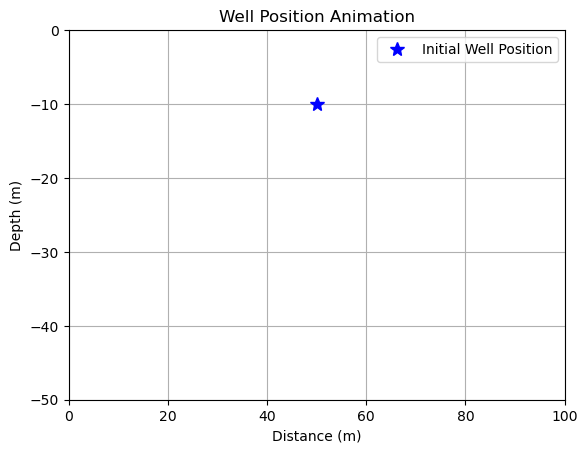

In [22]:
# Create a new figure and axis
plt.close('all')  # Close all existing figures
fig, ax = plt.subplots(figsize=(10, 6))

# Setup the plot with proper dimensions
ax.set_xlim(0, length)
ax.set_ylim(-depth, 0)
line, = ax.plot([], [], 'ro', markersize=10, label='Moving Well')
ax.grid(True)
ax.set_title('Well Position Animation')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Depth (m)')

# Add initial well position for reference
ax.plot(well_x, -10, 'b*', markersize=10, label='Initial Well Position')
ax.legend()

def init():
    line.set_data([], [])
    return line,

def animate(frame):
    # Calculate well position (moving in a circular pattern)
    x = well_x + 10 * np.cos(frame * 0.1)
    y = -10 + 5 * np.sin(frame * 0.1)  # Negative to match depth convention
    line.set_data([x], [y])
    return line,

# Create animation with repeat
ani = animation.FuncAnimation(fig, animate, init_func=init,
                            frames=100, interval=100, blit=True, repeat=True)

# Enable interactive mode
plt.ion()

# Show the plot and keep the animation running
plt.show()

# Keep reference to animation to prevent garbage collection
fig.ani = ani

C:\Users\gui\AppData\Local\Temp\ipykernel_11204\2790765246.py:41: UserWarning: frames=<function simData at 0x000001C34112D990> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, simPoints, simData, blit=False, interval=10,
C:\Users\gui\AppData\Local\Temp\ipykernel_11204\2790765246.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Error in callback <function _draw_all_if_interactive at 0x000001C37EC31750> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: x must be a sequence

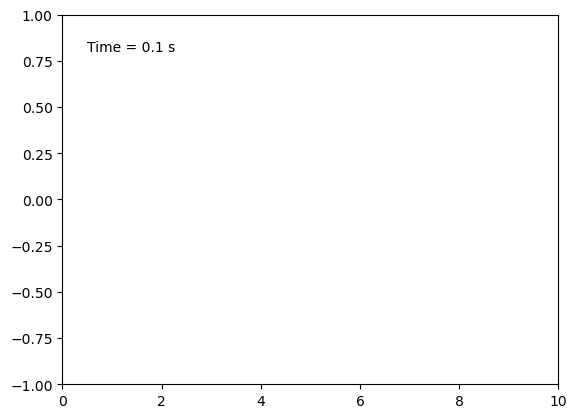

In [8]:
def onClick(event):
    global pause
    pause ^= True
fig.canvas.mpl_connect('button_press_event', onClick)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

pause = False
def simData():
    t_max = 10.0
    dt = 0.05
    x = 0.0
    t = 0.0
    while t < t_max:
        if not pause:
            x = np.sin(np.pi*t)
            t = t + dt
        yield x, t

def onClick(event):
    global pause
    pause ^= True

def simPoints(simData):
    x, t = simData[0], simData[1]
    time_text.set_text(time_template%(t))
    line.set_data(t, x)
    return line, time_text

fig = plt.figure()
ax = fig.add_subplot(111)
line, = ax.plot([], [], 'bo', ms=10)
ax.set_ylim(-1, 1)
ax.set_xlim(0, 10)

time_template = 'Time = %.1f s'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
fig.canvas.mpl_connect('button_press_event', onClick)
ani = animation.FuncAnimation(fig, simPoints, simData, blit=False, interval=10,
    repeat=True)
fig.show()